In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import model.graph_adj_x_diffusion as graph_adj_x_diffusion
import model.graph_net as graph_net
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import rdkit
import IPython
import importlib

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 1]
branch_defs = [((0, 1), 0.5, 1), ((0,), 0, 0.5), ((1,), 0, 0.5)]

# branch_defs = [((0, 1), 0.3, 1), ((0,), 0, 0.3), ((1,), 0, 0.3)]

# branch_defs = [((0, 1), 0.15, 1), ((0,), 0, 0.15), ((1,), 0, 0.15)]

In [4]:
dataset = molecule_dataset.ZINCDataset(label_method="num_cycles", nums_to_label=[0, 1])

# Limit classes
inds = np.isin(dataset.target, classes)
dataset.all_smiles = dataset.all_smiles[inds]
dataset.target = dataset.target[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
# Create the SDE and model
sde = graph_adj_x_diffusion.AXJointSDE(0.1, 1, 0.2, 1, input_shape)

t_limit = 1

model = graph_net.GraphJointNetwork(
    len(branch_defs), t_limit,
    a_shared_layers=[True, True, True, True, True, False, False],
    x_shared_layers=[True, True, False]
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_cycle_0_1"
importlib.reload(graph_adj_x_diffusion)

<module 'model.graph_adj_x_diffusion' from '/gstore/home/tsenga5/branched_diffusion/notebooks/../src/model/graph_adj_x_diffusion.py'>

### Show the forward-diffusion process

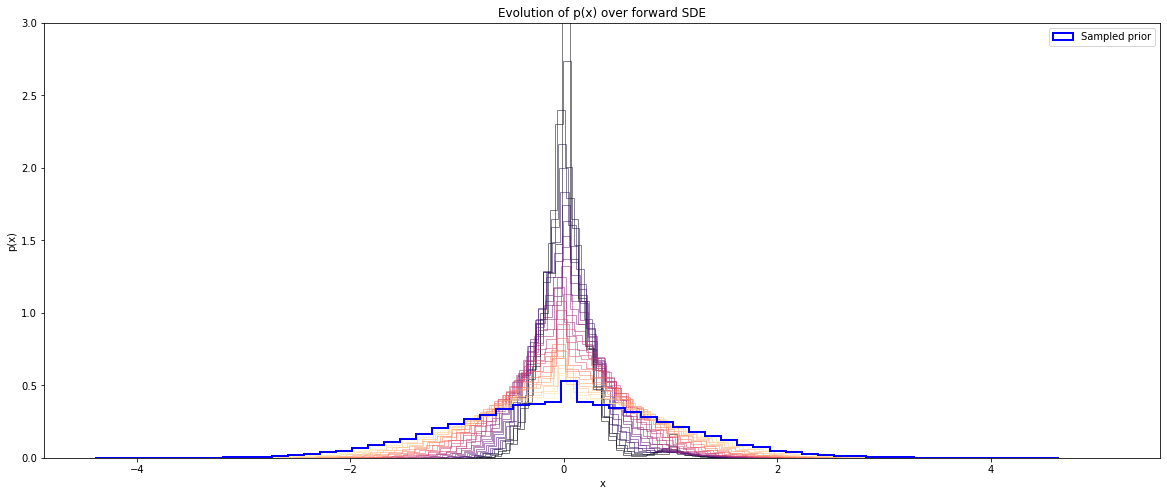

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
# import model.util as model_util
# model = model_util.load_model(
#     graph_net.GraphJointNetwork,
#     "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_cycle_0_1/1/last_ckpt.pth"
# ).to(DEVICE)

In [9]:
graph_adj_x_diffusion.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 200,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "6"
Loss: 461.72: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 1 average Loss: 838.47


Loss: 314.84: 100%|███████████████████████████████████████████████████| 170/170 [01:24<00:00,  2.00it/s]


Epoch 2 average Loss: 423.33


Loss: 332.61: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 3 average Loss: 382.39


Loss: 402.50: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  2.00it/s]


Epoch 4 average Loss: 361.89


Loss: 347.74: 100%|███████████████████████████████████████████████████| 170/170 [01:24<00:00,  2.00it/s]


Epoch 5 average Loss: 350.98


Loss: 291.40: 100%|███████████████████████████████████████████████████| 170/170 [01:24<00:00,  2.00it/s]


Epoch 6 average Loss: 338.23


Loss: 304.18: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 7 average Loss: 329.62


Loss: 370.23: 100%|███████████████████████████████████████████████████| 170/170 [01:24<00:00,  2.00it/s]


Epoch 8 average Loss: 321.83


Loss: 292.33: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 9 average Loss: 316.38


Loss: 323.30: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 10 average Loss: 311.60


Loss: 335.50: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 11 average Loss: 306.40


Loss: 268.31: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 12 average Loss: 304.78


Loss: 288.37: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  2.00it/s]


Epoch 13 average Loss: 299.18


Loss: 274.59: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 14 average Loss: 293.30


Loss: 294.80: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  2.00it/s]


Epoch 15 average Loss: 288.23


Loss: 240.83: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  2.00it/s]


Epoch 16 average Loss: 286.12


Loss: 344.83: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 17 average Loss: 285.72


Loss: 282.28: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 18 average Loss: 280.38


Loss: 342.81: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 19 average Loss: 277.39


Loss: 346.94: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 20 average Loss: 274.41


Loss: 282.23: 100%|███████████████████████████████████████████████████| 170/170 [01:24<00:00,  2.01it/s]


Epoch 21 average Loss: 271.85


Loss: 279.78: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 22 average Loss: 272.43


Loss: 271.34: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 23 average Loss: 267.12


Loss: 277.23: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 24 average Loss: 263.14


Loss: 301.98: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.98it/s]


Epoch 25 average Loss: 260.81


Loss: 237.16: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  2.00it/s]


Epoch 26 average Loss: 261.23


Loss: 267.28: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 27 average Loss: 258.99


Loss: 236.14: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  2.00it/s]


Epoch 28 average Loss: 256.54


Loss: 230.99: 100%|███████████████████████████████████████████████████| 170/170 [01:25<00:00,  1.99it/s]


Epoch 29 average Loss: 256.27


Loss: 220.96: 100%|███████████████████████████████████████████████████| 170/170 [01:32<00:00,  1.85it/s]


Epoch 30 average Loss: 253.73


Loss: 256.84: 100%|███████████████████████████████████████████████████| 170/170 [01:35<00:00,  1.79it/s]


Epoch 31 average Loss: 252.31


Loss: 222.47: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 32 average Loss: 249.09


Loss: 294.98: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 33 average Loss: 250.70


Loss: 207.13: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 34 average Loss: 245.46


Loss: 203.67: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 35 average Loss: 245.19


Loss: 220.21: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 36 average Loss: 243.86


Loss: 246.41: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 37 average Loss: 241.23


Loss: 209.50: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 38 average Loss: 243.99


Loss: 237.03: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 39 average Loss: 241.88


Loss: 256.77: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 40 average Loss: 240.94


Loss: 227.52: 100%|███████████████████████████████████████████████████| 170/170 [01:33<00:00,  1.81it/s]


Epoch 41 average Loss: 240.56


Loss: 209.82: 100%|███████████████████████████████████████████████████| 170/170 [01:35<00:00,  1.78it/s]


Epoch 42 average Loss: 240.10


Loss: 277.94: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 43 average Loss: 239.81


Loss: 227.60: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 44 average Loss: 238.39


Loss: 224.78: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 45 average Loss: 237.20


Loss: 237.70: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 46 average Loss: 236.09


Loss: 279.79: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 47 average Loss: 237.77


Loss: 217.55: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 48 average Loss: 235.76


Loss: 181.16: 100%|███████████████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 49 average Loss: 234.83


Loss: 211.38: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 50 average Loss: 235.84


Loss: 237.25: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 51 average Loss: 234.11


Loss: 214.07: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 52 average Loss: 234.17


Loss: 208.65: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 53 average Loss: 234.89


Loss: 305.01: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 54 average Loss: 232.15


Loss: 288.24: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 55 average Loss: 232.09


Loss: 165.02: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 56 average Loss: 229.52


Loss: 208.44: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 57 average Loss: 233.51


Loss: 225.84: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 58 average Loss: 229.06


Loss: 264.19: 100%|███████████████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 61 average Loss: 229.49


Loss: 225.48: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 62 average Loss: 228.45


Loss: 251.32: 100%|███████████████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 63 average Loss: 227.46


Loss: 254.54: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 64 average Loss: 229.48


Loss: 216.78: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 65 average Loss: 228.10


Loss: 254.32: 100%|███████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 66 average Loss: 228.35


Loss: 275.40: 100%|███████████████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 67 average Loss: 226.98


Loss: 215.95: 100%|███████████████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 68 average Loss: 227.46


Loss: 250.85:  76%|██████████████████████████████████████▋            | 129/170 [01:08<00:22,  1.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 267.18: 100%|██████████████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 77 average Loss: 223.70


Loss: 210.08: 100%|██████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 78 average Loss: 223.08


Loss: 225.96: 100%|██████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 79 average Loss: 226.14


Loss: 256.81: 100%|██████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 80 average Loss: 223.79


Loss: 231.97: 100%|██████████████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 81 average Loss: 224.20


Loss: 190.34: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 82 average Loss: 221.11


Loss: 191.69: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 83 average Loss: 222.63


Loss: 230.22: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 84 average Loss: 222.44


Loss: 213.52: 100%|████████████████████████████████████████| 170/170 [01:32<00:00,  1.84it/s]


Epoch 85 average Loss: 221.97


Loss: 216.31: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 86 average Loss: 222.11


Loss: 206.26: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 87 average Loss: 221.31


Loss: 210.15: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 88 average Loss: 220.84


Loss: 208.66: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 89 average Loss: 220.16


Loss: 228.09: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 90 average Loss: 220.17


Loss: 196.22: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 91 average Loss: 219.45


Loss: 215.91: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 92 average Loss: 221.31


Loss: 200.11: 100%|████████████████████████████████████████| 170/170 [01:32<00:00,  1.84it/s]


Epoch 93 average Loss: 219.68


Loss: 211.84: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 94 average Loss: 222.00


Loss: 197.90: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 95 average Loss: 218.70


Loss: 208.87: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 96 average Loss: 221.08


Loss: 227.80: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 97 average Loss: 219.74


Loss: 212.08: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 98 average Loss: 219.45


Loss: 223.45: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.90it/s]


Epoch 99 average Loss: 220.22


Loss: 187.26: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 100 average Loss: 218.72


Loss: 208.45: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 101 average Loss: 218.59


Loss: 217.39: 100%|████████████████████████████████████████| 170/170 [01:35<00:00,  1.78it/s]


Epoch 102 average Loss: 218.55


Loss: 215.40: 100%|████████████████████████████████████████| 170/170 [01:36<00:00,  1.76it/s]


Epoch 103 average Loss: 217.83


Loss: 207.58: 100%|████████████████████████████████████████| 170/170 [01:32<00:00,  1.84it/s]


Epoch 104 average Loss: 219.65


Loss: 191.93: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 105 average Loss: 217.65


Loss: 187.44: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 106 average Loss: 217.93


Loss: 216.29: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 107 average Loss: 218.73


Loss: 197.13: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 108 average Loss: 216.10


Loss: 293.19: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 109 average Loss: 218.43


Loss: 202.55: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 111 average Loss: 217.21


Loss: 224.10: 100%|████████████████████████████████████████| 170/170 [01:32<00:00,  1.85it/s]


Epoch 112 average Loss: 217.32


Loss: 225.45: 100%|████████████████████████████████████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 113 average Loss: 217.16


Loss: 202.94: 100%|████████████████████████████████████████| 170/170 [01:36<00:00,  1.77it/s]


Epoch 114 average Loss: 215.06


Loss: 202.97: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 115 average Loss: 216.09


Loss: 231.43: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 116 average Loss: 215.92


Loss: 196.99: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 117 average Loss: 215.26


Loss: 216.35: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 118 average Loss: 214.44


Loss: 186.35: 100%|████████████████████████████████████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 119 average Loss: 214.91


Loss: 218.25:  10%|████                                     | 17/170 [00:09<01:22,  1.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 202.03: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 156 average Loss: 210.74


Loss: 260.61: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 157 average Loss: 211.00


Loss: 242.82: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 158 average Loss: 210.42


Loss: 197.52: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 159 average Loss: 211.20


Loss: 186.83: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 160 average Loss: 210.13


Loss: 213.34: 100%|████████████████████████████████████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 161 average Loss: 212.46


Loss: 181.30: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 162 average Loss: 210.80


Loss: 215.10: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 163 average Loss: 209.71


Loss: 202.53: 100%|████████████████████████████████████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 164 average Loss: 211.14


Loss: 202.58:  56%|███████████████████████▏                 | 96/170 [00:51<00:38,  1.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 271.43: 100%|████████████████████████████████████████| 170/170 [01:28<00:00,  1.93it/s]
INFO - train - Completed after 4:59:56


Epoch 200 average Loss: 207.23


### Show generated distributions

In [10]:
samples = {}
num_samples_per_class = 32
for class_to_sample in classes:
    # Sample some initial node flags
    inds = np.random.choice(np.where(dataset.target == class_to_sample)[0], size=num_samples_per_class, replace=True)
    batch = torch.stack([dataset[i][0] for i in inds], dim=0)
    adj = batch[:, :, :batch.shape[1]]
    sampled_flags = graph_net.node_flags(adj)
    
    sample = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampled_flags, num_samples=num_samples_per_class, t_limit=t_limit,
        num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.62it/s]


In [11]:
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]
BOND_TYPES = [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE]

def samples_to_adj_x(samps):
    """
    Given a B x M x (M + D) array of adjacency matrices and node features,
    discretizes them and returns the adjacency matrices (B x M x M) and
    node features (B x M x D),
    """
    s = samps.shape[1]
    adj, x = samps[:, :, :s], samps[:, :, s:]
    
    # Discretize
    adj[adj < 0.5] = 0
    adj[(adj >= 0.5) & (adj < 1.5)] = 1
    adj[(adj >= 1.5) & (adj < 2.5)] = 2
    adj[adj >= 2.5] = 3
    adj = np.triu(adj, k=1)
    adj = adj + np.swapaxes(adj, 1, 2)
    x[x < 0.5] = 0
    x[x >= 0.5] = 1
    adj, x = adj.astype(int), x.astype(int)
    return adj, x

def samples_to_rdkmols(adj, x, flags):
    """
    Given a B x M x M adjacency matrix batch and B x M x D node feature
    batch, and a B x M binary array of flags (all NumPy arrays),
    converts them to RDKit molecule objects.
    """
    mol_sizes = np.sum(flags, axis=1)
    atomic_nums = np.argmax(x, axis=2)
    
    mols = []
    for i in range(len(adj)):
        size = mol_sizes[i]
        a, atoms = adj[i][:size][:, :size], atomic_nums[i][:size]
        mol = rdkit.Chem.RWMol()
        
        for atom in atoms:
            mol.AddAtom(rdkit.Chem.Atom(ATOM_SYMBOLS[atom]))
            
        for u, v in zip(*np.nonzero(np.triu(a, k=1))):
            mol.AddBond(int(u), int(v), BOND_TYPES[a[u, v] - 1])
        
        mol.UpdatePropertyCache(strict=False)  # Set valences
        
        mols.append(mol)
    return mols

def plot_molecule(mol):
    mc = rdkit.Chem.Mol(mol.ToBinary())
    rdkit.Chem.Kekulize(mc)
    
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(450, 150)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return IPython.display.SVG(svg.replace("svg:",""))

In [12]:
# Convert to molecule objects
mol_samples = {}
for class_to_sample in classes:
    samps = samples[class_to_sample]
    
    # Separate and discretize
    adj, x = samples_to_adj_x(samps)
    
    # Convert
    mol_samples[class_to_sample] = samples_to_rdkmols(adj, x, sampled_flags.cpu().numpy().astype(int))

0


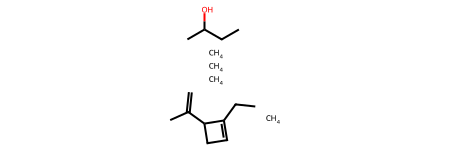

C.C.C.C.C=C(C)C1CC=C1CC.CCC(C)O


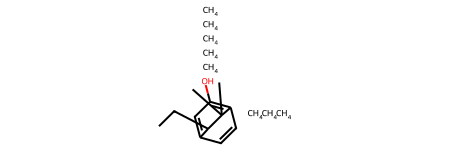

C.C.C.C.C.C.C.C.CCC1C2=CC(O)=C(C=C2)C1(C)C


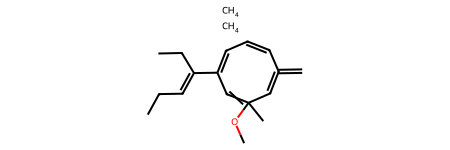

C.C.C=C1=CC(C)(OC)=CC(C(=CCC)CC)=CC=C1


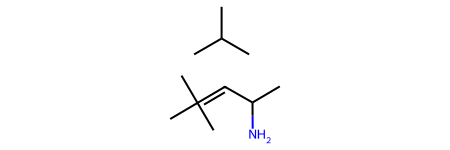

CC(C)C.CC(N)C=C(C)(C)C


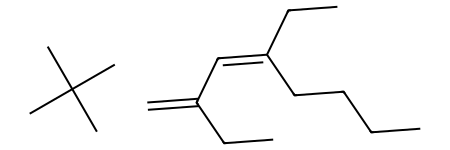

C=C(C=C(CC)CCCC)CC.CC(C)(C)C


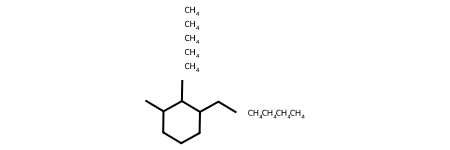

C.C.C.C.C.C.C.C.C.CCC1CCCC(C)C1C


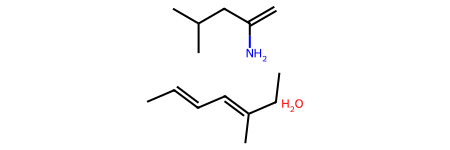

C=C(N)CC(C)C.CC=CC=C(C)CC.O


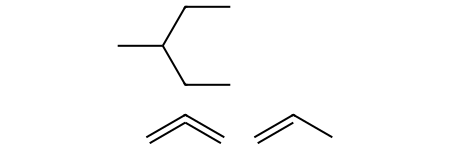

C=C=C.C=CC.CCC(C)CC


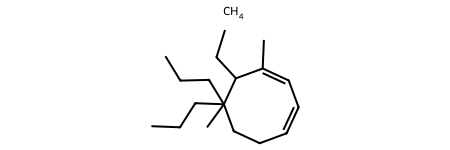

C.CCCC1(C)(CCC)CCC=CC=C(C)C1CC


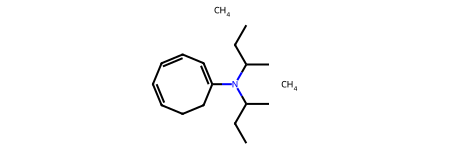

C.C.CCC(C)N(C1=CC=CC=CCC1)C(C)CC


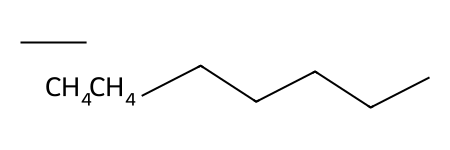

C.C.CC.CCCCCC


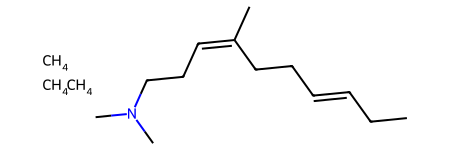

C.C.C.CCC=CCCC(C)=CCCN(C)C


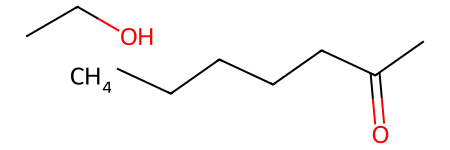

C.CCCCCC(C)=O.CCO


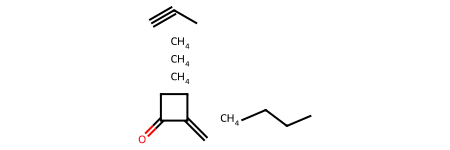

C.C.C.C.C#CC.C=C1CCC1=O.CCCC


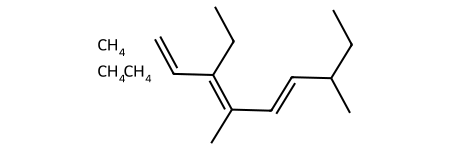

C.C.C.C=CC(CC)=C(C)C=CC(C)CC


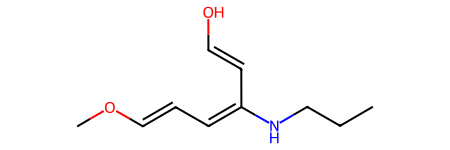

CCCNC(C=CO)=CC=COC


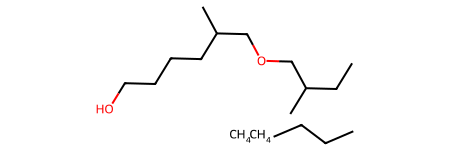

C.C.CCC(C)COCC(C)CCCCO.CCCC


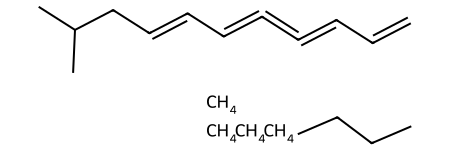

C.C.C.C.C=CC=C=C=CC=CCC(C)C.CCCC


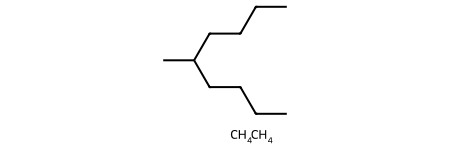

C.C.CCCCC(C)CCCC


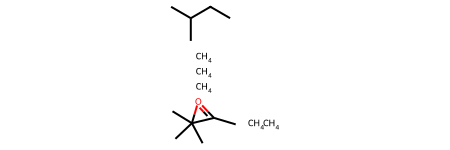

C.C.C.C.C.CC1=OC1(C)(C)C.CCC(C)C


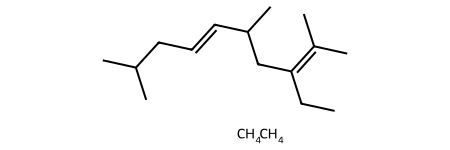

C.C.CCC(CC(C)C=CCC(C)C)=C(C)C


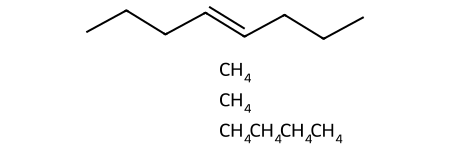

C.C.C.C.C.C.CCCC=CCCC


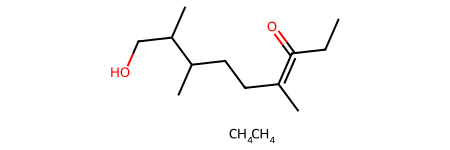

C.C.CCC(=O)=C(C)CCC(C)C(C)CO


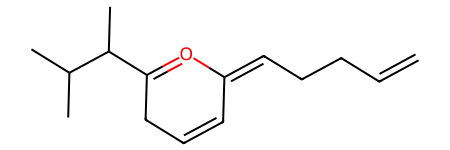

C=CCCC=C1C=CCC(C(C)C(C)C)=O1


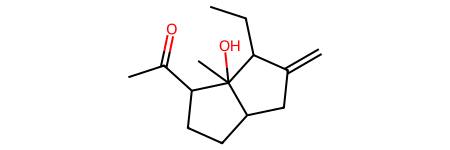

C=C1CC2CCC(C(C)=O)C2(C)(O)C1CC


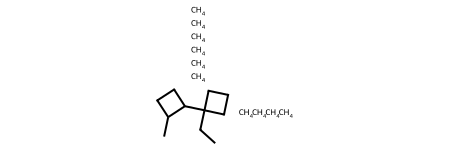

C.C.C.C.C.C.C.C.C.C.CCC1(C2CCC2C)CCC1


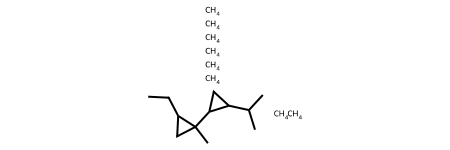

C.C.C.C.C.C.C.C.CCC1CC1(C)C1CC1C(C)C


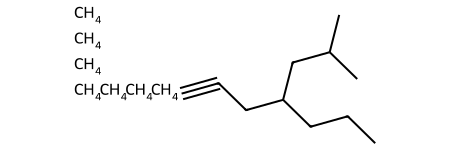

C.C.C.C.C.C.C.C#CCC(CCC)CC(C)C


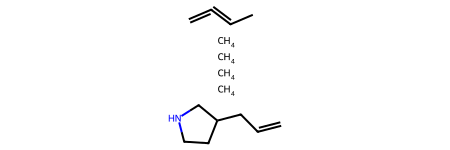

C.C.C.C.C=C=CC.C=CCC1CCNC1


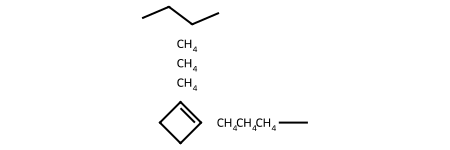

C.C.C.C.C.C.C1=CCC1.CC.CCCC


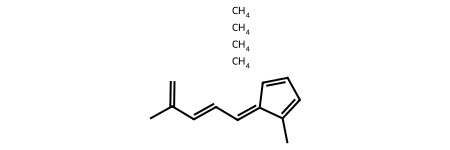

C.C.C.C.C=C(C)C=CC=C1C=CC=C1C


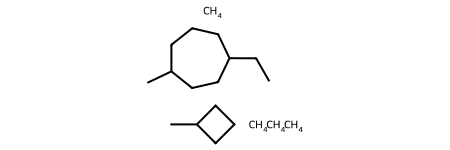

C.C.C.C.CC1CCC1.CCC1CCCC(C)CC1
1


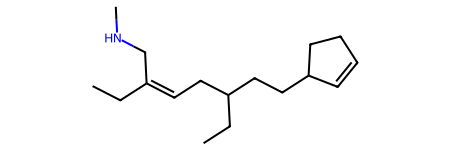

CCC(=CCC(CC)CCC1C=CCC1)CNC


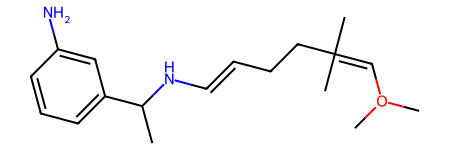

CC(NC=CCCC(C)(C)=CO(C)C)C1=CC=CC(N)=C1


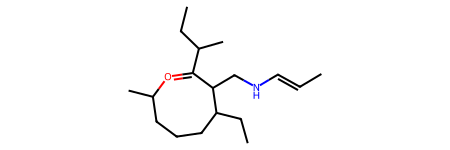

CC=CNCC1C(C(C)CC)=OC(C)CCCC1CC


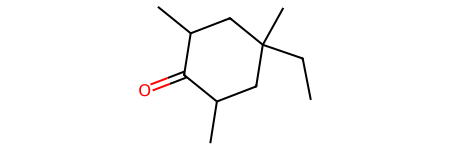

CCC1(C)CC(C)C(=O)C(C)C1


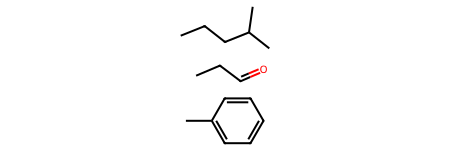

CC1=CC=CC=C1.CCC=O.CCCC(C)C


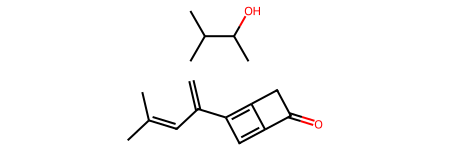

C=C(C=C(C)C)C1=C2CC(=O)C2=C1.CC(C)C(C)O


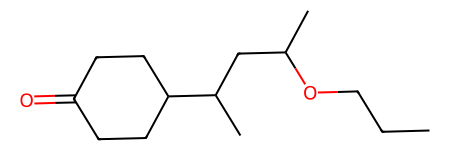

CCCOC(C)CC(C)C1CCC(=O)CC1


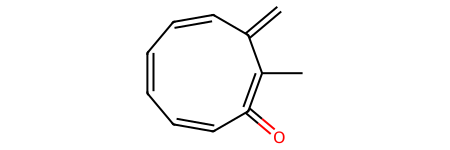

C=C1C=CC=CC=CC(=O)=C1C


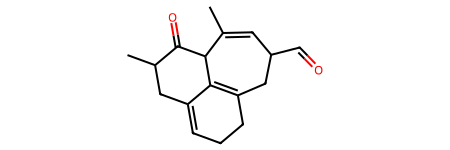

CC1=CC(C=O)CC2=C3C(=CCC2)CC(C)C(=O)C13


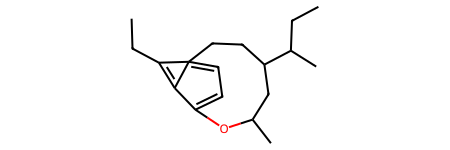

CCC1=C2C3=CC=C12CCC(C(C)CC)CC(C)O3


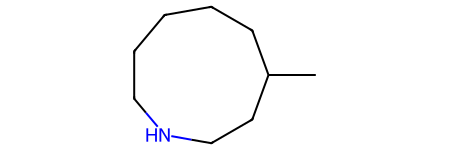

CC1CCCCCNCC1


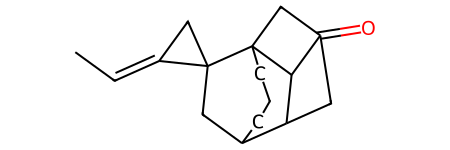

CC=C1CC12CC1CCCC23CC2(=O)CC1C32


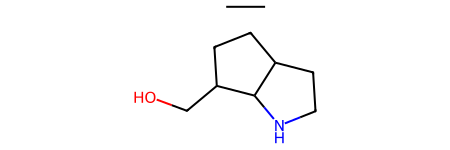

CC.OCC1CCC2CCNC12


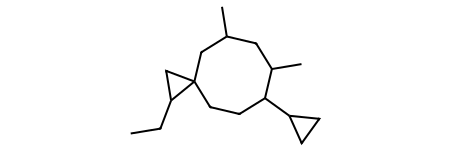

CCC1CC12CCC(C1CC1)C(C)CC(C)C2


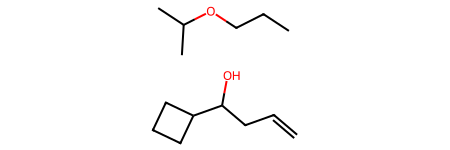

C=CCC(O)C1CCC1.CCCOC(C)C


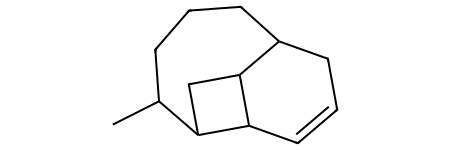

CC1CCCC2CC=CC3C1CC23


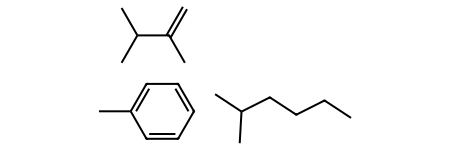

C=C(C)C(C)C.CC1=CC=CC=C1.CCCCC(C)C


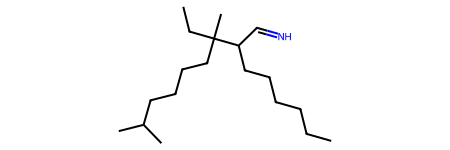

CCCCCCC(C=N)C(C)(CC)CCCCC(C)C


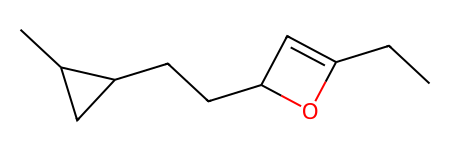

CCC1=CC(CCC2CC2C)O1


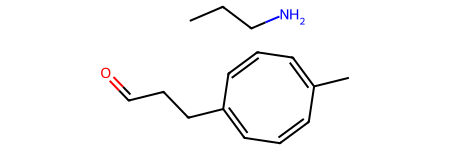

CC1=CC=CC(CCC=O)=CC=C1.CCCN


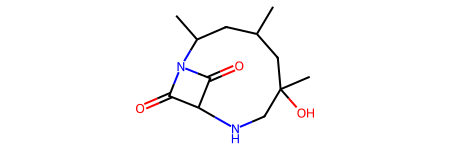

CC1CC(C)N2C(=O)C(NCC(C)(O)C1)C2=O


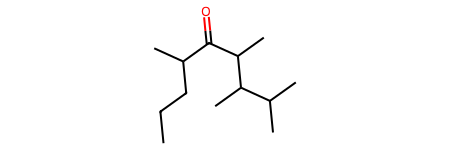

CCCC(C)C(=O)C(C)C(C)C(C)C


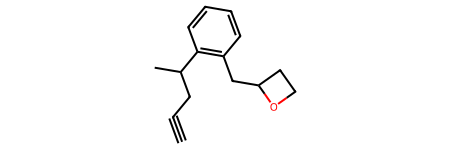

C#CCC(C)C1=C(CC2CCO2)C=CC=C1


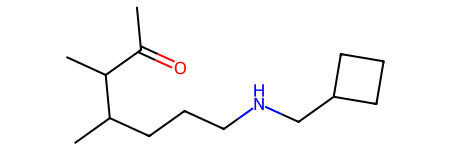

CC(=O)C(C)C(C)CCCNCC1CCC1


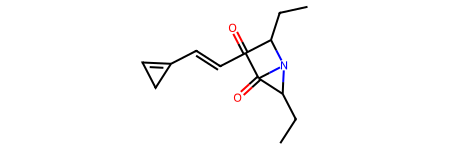

CCC1N2C(CC)C2(=O)C1(=O)C=CC1=CC1


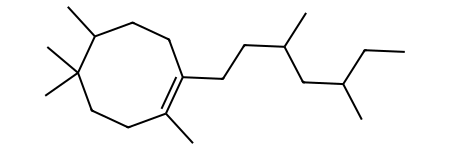

CCC(C)CC(C)CCC1=C(C)CCC(C)(C)C(C)CC1


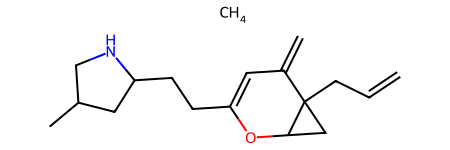

C.C=CCC12CC1OC(CCC1CC(C)CN1)=CC2=C


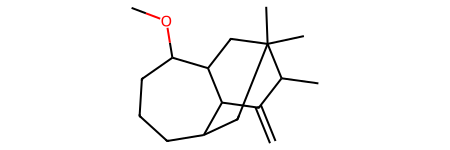

C=C1C2C3CCCC(OC)C2CC(C)(C)(C3)C1C


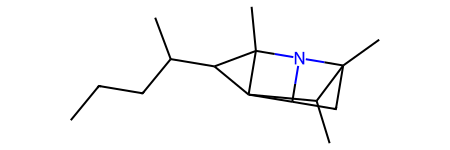

CCCC(C)C1C23C4CC(C)(C2C)N4C13C


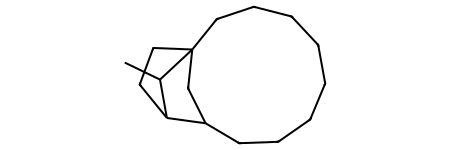

CC1C2CCC13CCCCCCCCC2C3


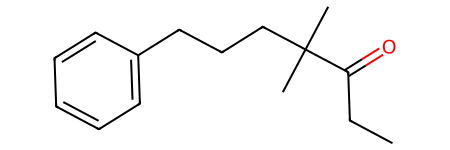

CCC(=O)C(C)(C)CCCC1=CC=CC=C1


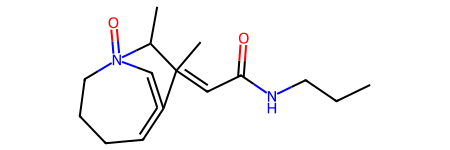

CCCNC(=O)C=C1(C)C2=CCCCN(=O)(C=2)C1C


In [13]:
for class_to_sample in classes:
    print(class_to_sample)
    for mol in mol_samples[class_to_sample]:
        IPython.display.display(plot_molecule(mol))
        print(rdkit.Chem.MolToSmiles(mol))

### Transmutation

In [14]:
class_1, class_2 = 0, 1
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_2)[0], size=200, replace=False)
])
orig_1_adj = orig_1[:, :, :orig_1.shape[1]]
orig_1_flags = graph_net.node_flags(orig_1_adj)
orig_2_adj = orig_2[:, :, :orig_2.shape[1]]
orig_2_flags = graph_net.node_flags(orig_2_adj)

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
for t_i, t in enumerate(all_t):
    if t_i == 0:
        forward_1_to_2[t_i], forward_2_to_1[t_i] = orig_1.cpu().numpy(), orig_2.cpu().numpy()
    else:
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor,
        orig_1_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

    last_2_to_1 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor,
        orig_2_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

orig_1, orig_2 = orig_1.cpu().numpy(), orig_2.cpu().numpy()
before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]

In [15]:
# Convert to molecule objects
before_1_to_2_adj, before_1_to_2_x = samples_to_adj_x(before_1_to_2)
before_1_to_2_mols = samples_to_rdkmols(before_1_to_2_adj, before_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
after_1_to_2_adj, after_1_to_2_x = samples_to_adj_x(after_1_to_2)
after_1_to_2_mols = samples_to_rdkmols(after_1_to_2_adj, after_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
before_2_to_1_adj, before_2_to_1_x = samples_to_adj_x(before_2_to_1)
before_2_to_1_mols = samples_to_rdkmols(before_2_to_1_adj, before_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))
after_2_to_1_adj, after_2_to_1_x = samples_to_adj_x(after_2_to_1)
after_2_to_1_mols = samples_to_rdkmols(after_2_to_1_adj, after_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))

0 to 1
0


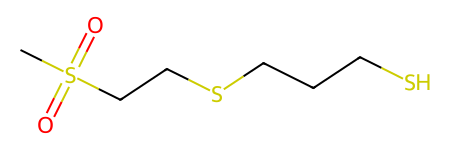

CS(=O)(=O)CCSCCCS


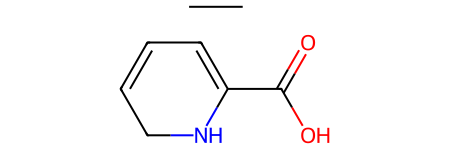

CC.O=C(O)C1=CC=CCN1
1


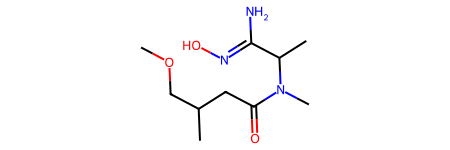

COCC(C)CC(=O)N(C)C(C)C(N)=NO


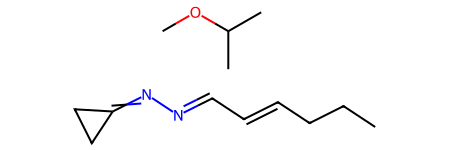

CCCC=CC=NN=C1CC1.COC(C)C
2


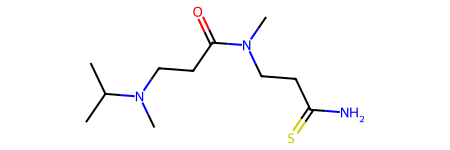

CC(C)N(C)CCC(=O)N(C)CCC(N)=S


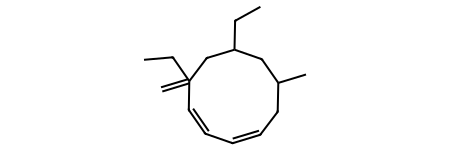

C=C1(CC)C=CC=CCC(C)CC(CC)C1
3


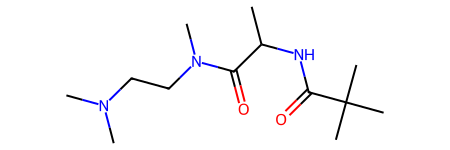

CC(NC(=O)C(C)(C)C)C(=O)N(C)CCN(C)C


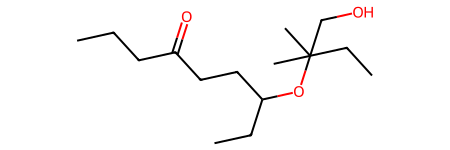

CCCC(=O)CCC(CC)OC(C)(C)(CC)CO
4


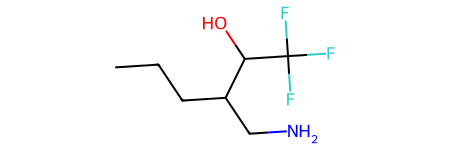

CCCC(CN)C(O)C(F)(F)F


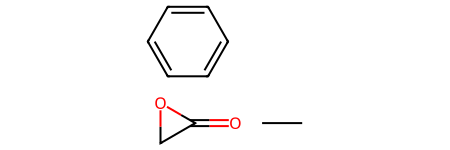

C1=CC=CC=C1.CC.O=C1CO1
5


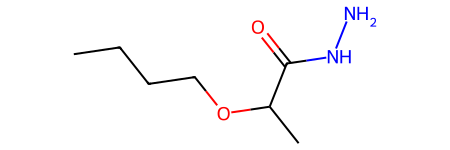

CCCCOC(C)C(=O)NN


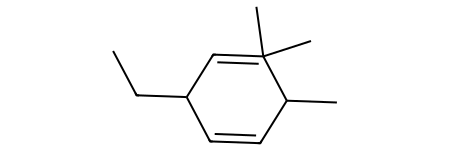

CCC1C=CC(C)C(C)(C)=C1
6


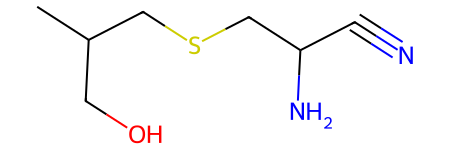

CC(CO)CSCC(N)C#N


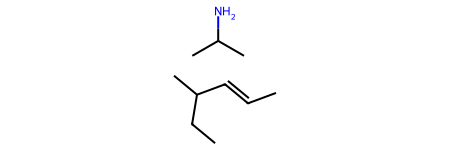

CC(C)N.CC=CC(C)CC
7


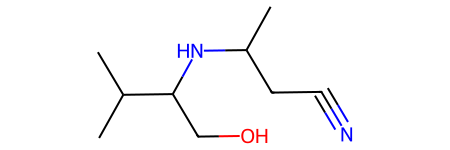

CC(CC#N)NC(CO)C(C)C


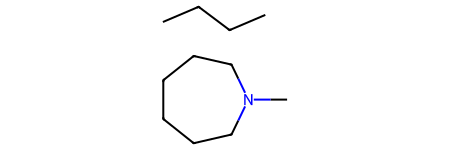

CCCC.CN1CCCCCC1
8


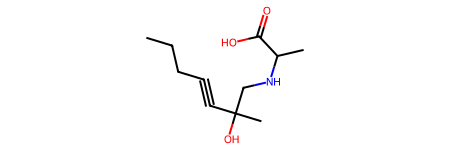

CCCC#CC(C)(O)CNC(C)C(=O)O


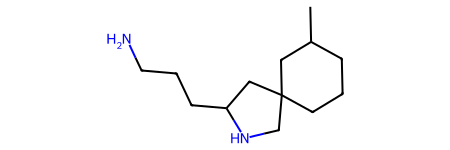

CC1CCCC2(CNC(CCCN)C2)C1
9


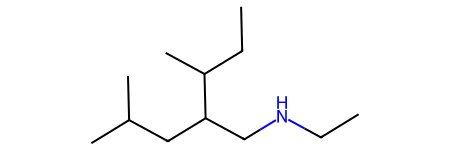

CCNCC(CC(C)C)C(C)CC


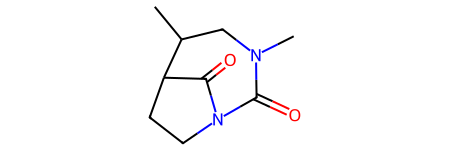

CC1CN(C)C(=O)N2CCC1C2=O
10


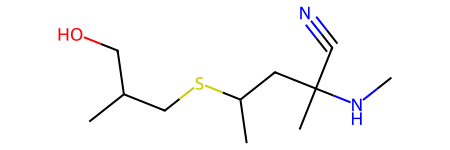

CNC(C)(C#N)CC(C)SCC(C)CO


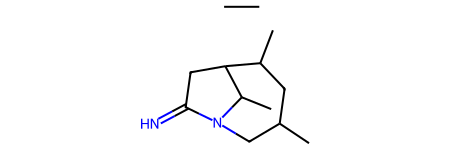

CC.CC1CC(C)C2CC(=N)N(C1)C2C
11


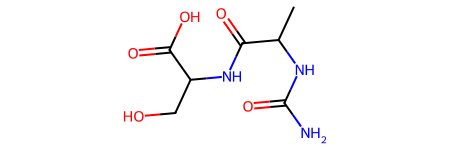

CC(NC(N)=O)C(=O)NC(CO)C(=O)O


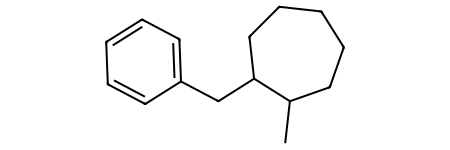

CC1CCCCCC1CC1=CC=CC=C1
12


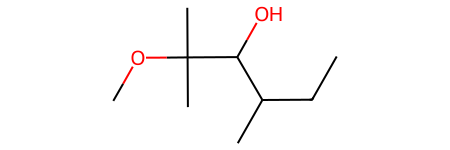

CCC(C)C(O)C(C)(C)OC


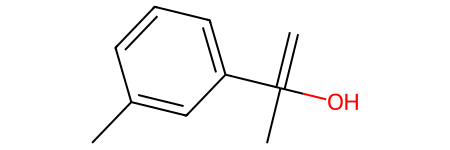

C=C(C)(O)C1=CC=CC(C)=C1
13


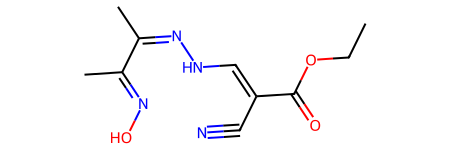

CCOC(=O)C(C#N)=CNN=C(C)C(C)=NO


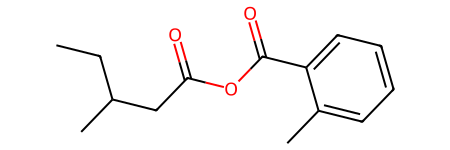

CCC(C)CC(=O)OC(=O)C1=CC=CC=C1C
14


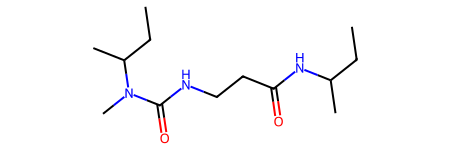

CCC(C)NC(=O)CCNC(=O)N(C)C(C)CC


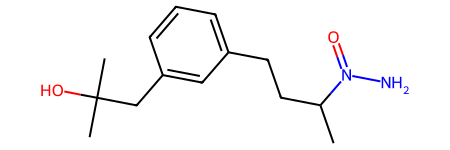

CC(CCC1=CC=CC(CC(C)(C)O)=C1)N(N)=O
15


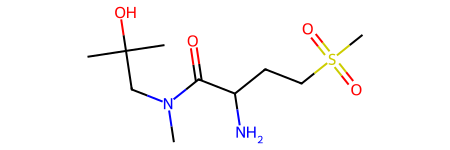

CN(CC(C)(C)O)C(=O)C(N)CCS(C)(=O)=O


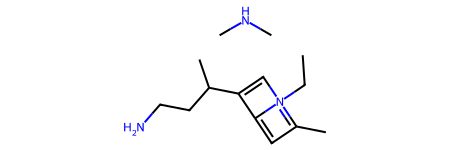

CCN12=C(C)C=C1C(C(C)CCN)=C2.CNC
16


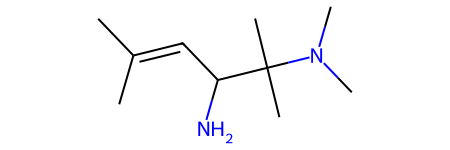

CC(C)=CC(N)C(C)(C)N(C)C


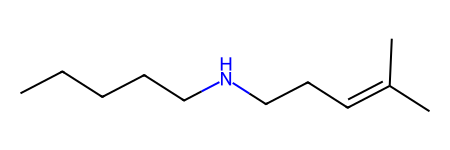

CCCCCNCCC=C(C)C
17


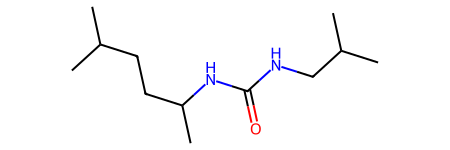

CC(C)CCC(C)NC(=O)NCC(C)C


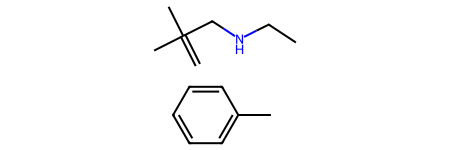

C=C(C)(C)CNCC.CC1=CC=CC=C1
18


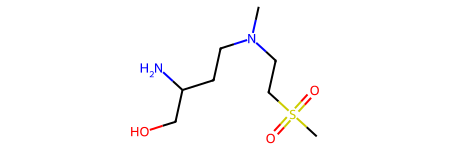

CN(CCC(N)CO)CCS(C)(=O)=O


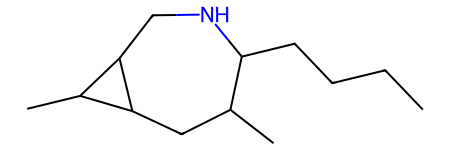

CCCCC1NCC2C(C)C2CC1C
19


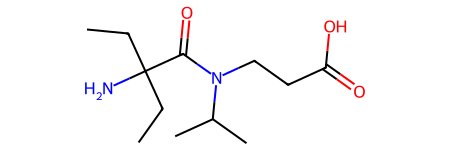

CCC(N)(CC)C(=O)N(CCC(=O)O)C(C)C


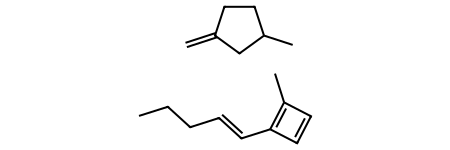

C=C1CCC(C)C1.CCCC=CC1=C(C)C=C1
20


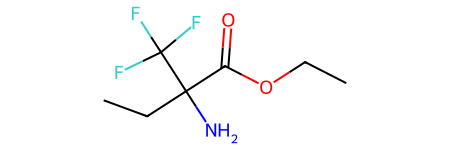

CCOC(=O)C(N)(CC)C(F)(F)F


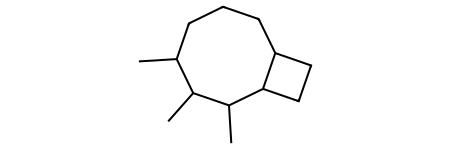

CC1CCCC2CCC2C(C)C1C
21


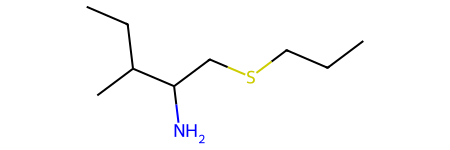

CCCSCC(N)C(C)CC


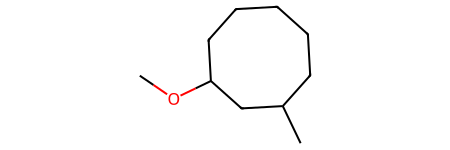

COC1CCCCCC(C)C1
22


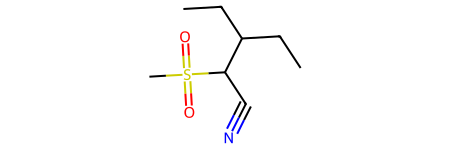

CCC(CC)C(C#N)S(C)(=O)=O


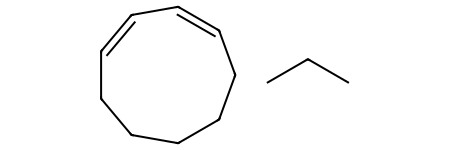

C1=CCCCCCC=C1.CCC
23


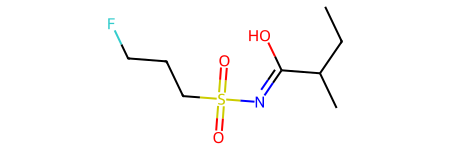

CCC(C)C(O)=NS(=O)(=O)CCCF


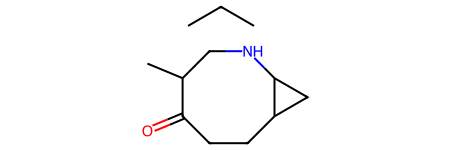

CC1CNC2CC2CCC1=O.CCC
24


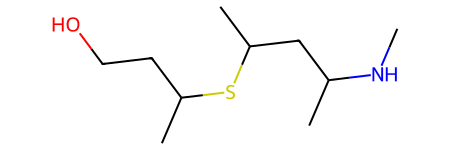

CNC(C)CC(C)SC(C)CCO


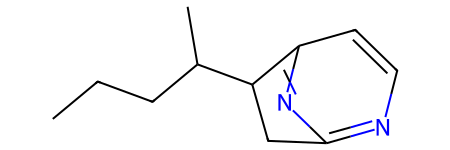

CCCC(C)C1CC2=NC=CC1=N2
25


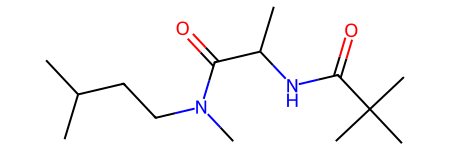

CC(C)CCN(C)C(=O)C(C)NC(=O)C(C)(C)C


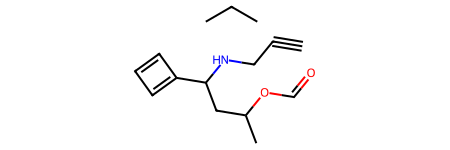

C#CCNC(CC(C)OC=O)C1=CC=C1.CCC
26


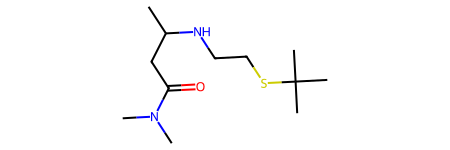

CC(CC(=O)N(C)C)NCCSC(C)(C)C


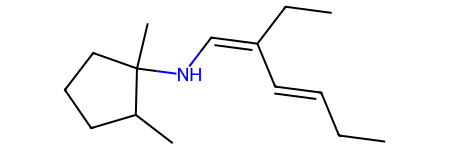

CCC=CC(=CNC1(C)CCCC1C)CC
27


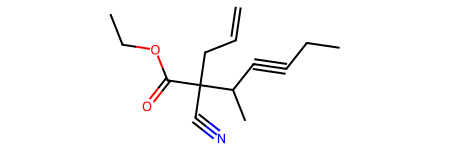

C=CCC(C#N)(C(=O)OCC)C(C)C#CCC


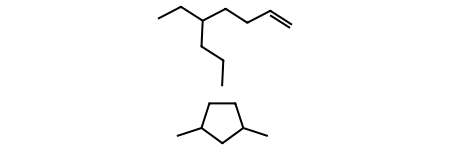

C=CCCC(CC)CCC.CC1CCC(C)C1
28


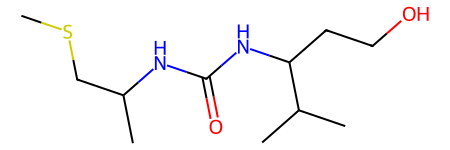

CSCC(C)NC(=O)NC(CCO)C(C)C


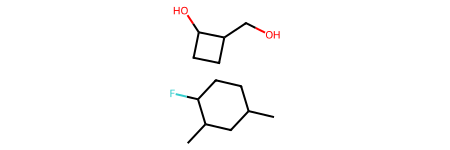

CC1CCC(F)C(C)C1.OCC1CCC1O
29


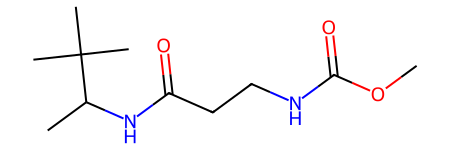

COC(=O)NCCC(=O)NC(C)C(C)(C)C


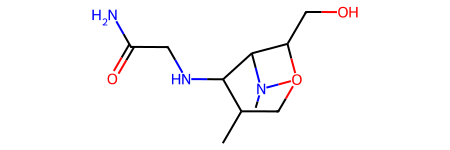

CC1CO2C(CO)C(C1NCC(N)=O)N2C
30


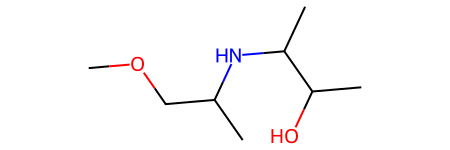

COCC(C)NC(C)C(C)O


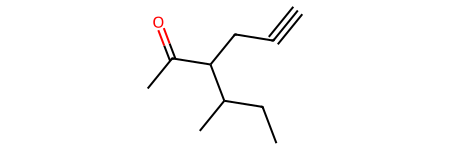

C#CCC(C(C)=O)C(C)CC
31


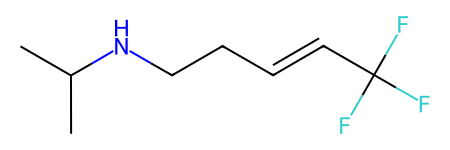

CC(C)NCCC=CC(F)(F)F


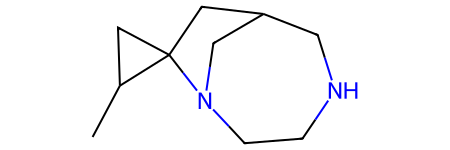

CC1CC12CC1CNCCN2C1
1 to 0
0


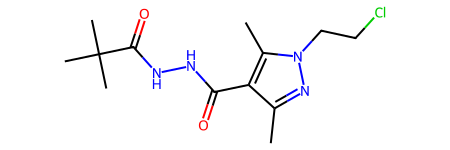

CC1=NN(CCCl)C(C)=C1C(=O)NNC(=O)C(C)(C)C


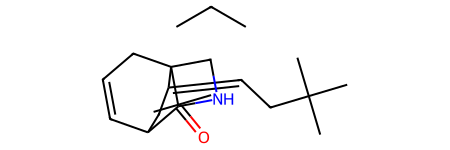

CC(C)(C)CC=C1C=C2C=CCC13CNC23=O.CCC
1


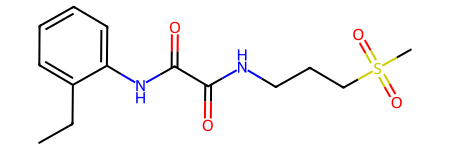

CCC1=CC=CC=C1NC(=O)C(=O)NCCCS(C)(=O)=O


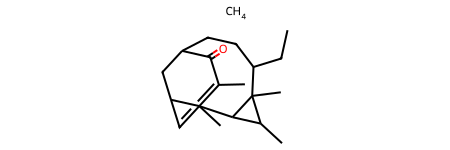

C.CCC1CCC2CC3C=C3(C)(=C(C)C2=O)C2C(C)C12C
2


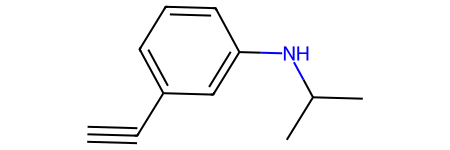

C#CC1=CC=CC(NC(C)C)=C1


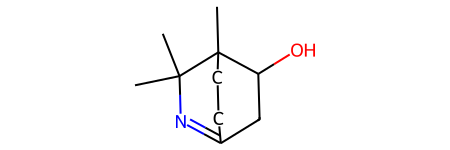

CC1(C)N=C2CCC1(C)C(O)C2
3


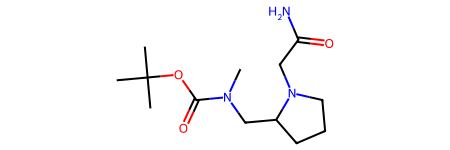

CN(CC1CCCN1CC(N)=O)C(=O)OC(C)(C)C


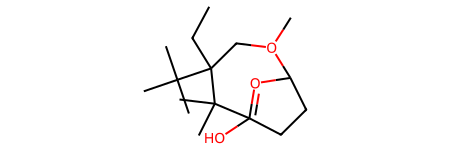

CCC1(C(C)(C)C)CO(C)C2CCC(O)(=O2)C1(C)C
4


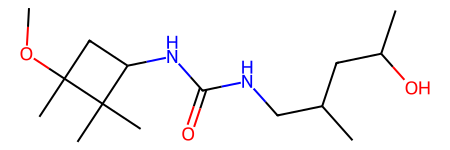

COC1(C)CC(NC(=O)NCC(C)CC(C)O)C1(C)C


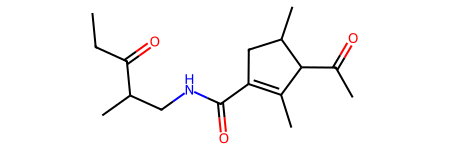

CCC(=O)C(C)CNC(=O)C1=C(C)C(C(C)=O)C(C)C1
5


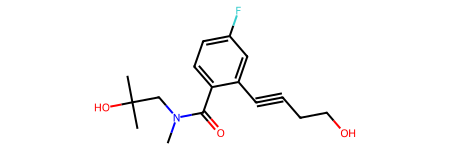

CN(CC(C)(C)O)C(=O)C1=CC=C(F)C=C1C#CCCO


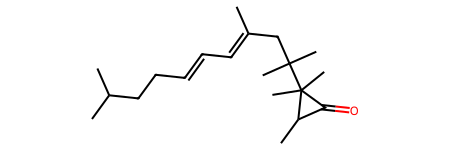

CC(=CC=CCCC(C)C)CC(C)(C)C1(C)(C)C(=O)C1C
6


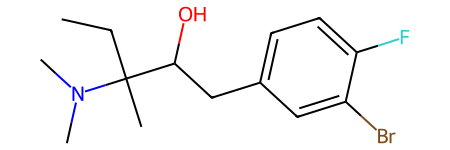

CCC(C)(C(O)CC1=CC=C(F)C(Br)=C1)N(C)C


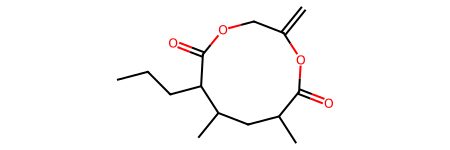

C=C1COC(=O)C(CCC)C(C)CC(C)C(=O)O1
7


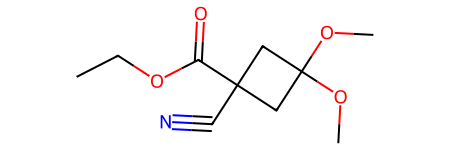

CCOC(=O)C1(C#N)CC(OC)(OC)C1


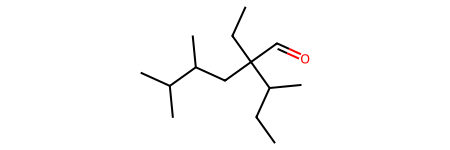

CCC(C)C(C=O)(CC)CC(C)C(C)C
8


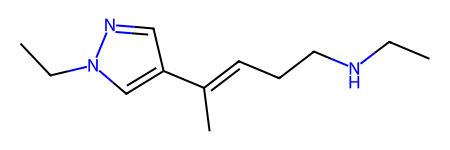

CCNCCC=C(C)C1=CN(CC)N=C1


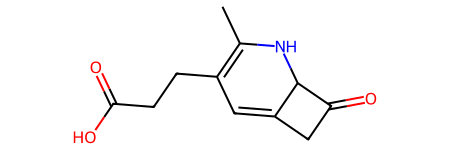

CC1=C(CCC(=O)O)C=C2CC(=O)C2N1
9


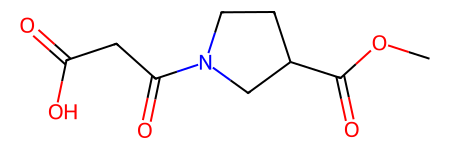

COC(=O)C1CCN(C(=O)CC(=O)O)C1


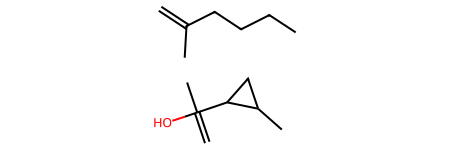

C=C(C)(O)C1CC1C.C=C(C)CCCC
10


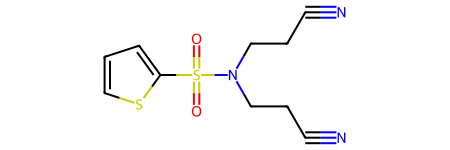

N#CCCN(CCC#N)S(=O)(=O)C1=CC=CS1


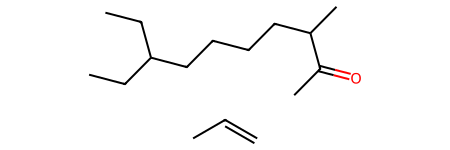

C=CC.CCC(CC)CCCCC(C)C(C)=O
11


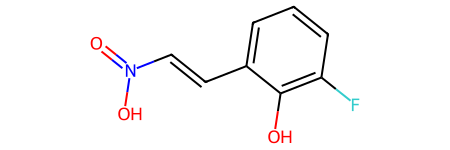

O=N(O)C=CC1=CC=CC(F)=C1O


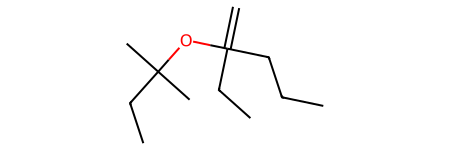

C=C(CC)(CCC)OC(C)(C)CC
12


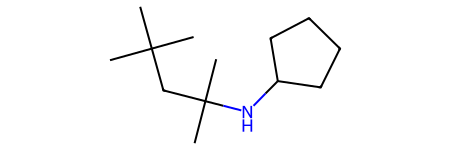

CC(C)(C)CC(C)(C)NC1CCCC1


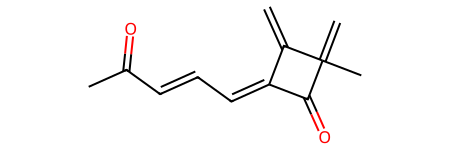

C=C1C(=CC=CC(C)=O)C(=O)C1(=C)C
13


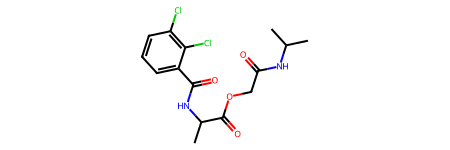

CC(C)NC(=O)COC(=O)C(C)NC(=O)C1=CC=CC(Cl)=C1Cl


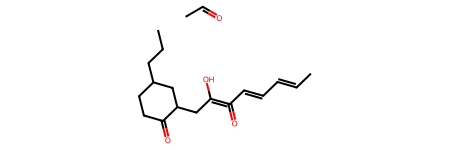

CC=CC=CC(=O)=C(O)CC1CC(CCC)CCC1=O.CC=O
14


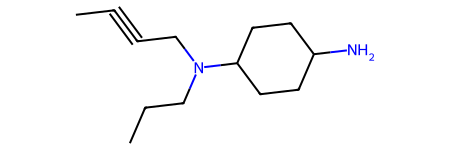

CC#CCN(CCC)C1CCC(N)CC1


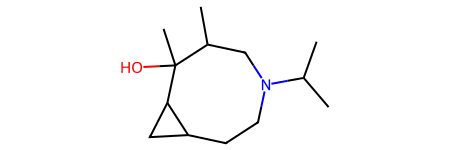

CC(C)N1CCC2CC2C(C)(O)C(C)C1
15


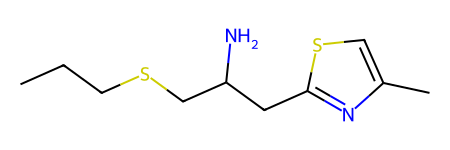

CCCSCC(N)CC1=NC(C)=CS1


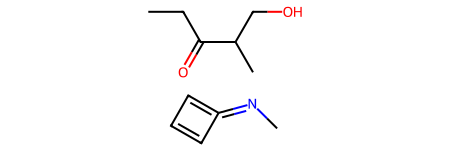

CCC(=O)C(C)CO.CN=C1=CC=C1
16


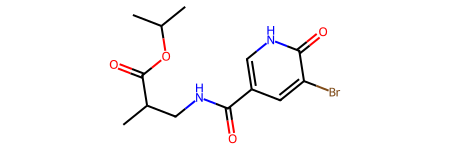

CC(C)OC(=O)C(C)CNC(=O)C1=CNC(=O)C(Br)=C1


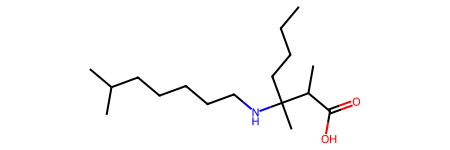

CCCCC(C)(NCCCCCC(C)C)C(C)C(=O)O
17


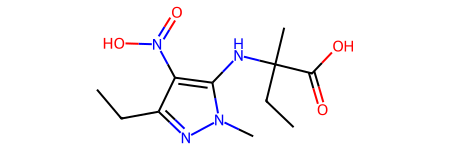

CCC1=NN(C)C(NC(C)(CC)C(=O)O)=C1N(=O)O


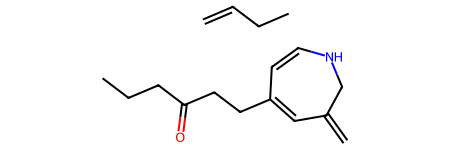

C=C1C=C(CCC(=O)CCC)C=CNC1.C=CCC
18


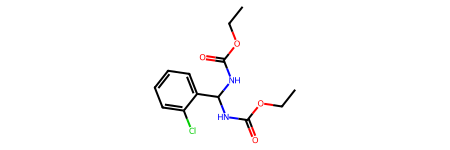

CCOC(=O)NC(NC(=O)OCC)C1=CC=CC=C1Cl


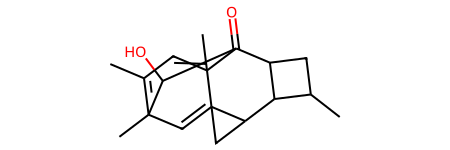

CC1=C2(C)C=C34CC3C3C(C)CC3C(=O)(C2O)C4(C)=C1
19


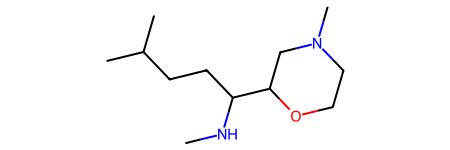

CNC(CCC(C)C)C1CN(C)CCO1


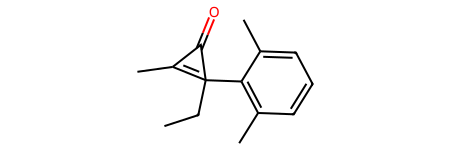

CCC1(C2=C(C)C=CC=C2C)=C(C)C1=O
20


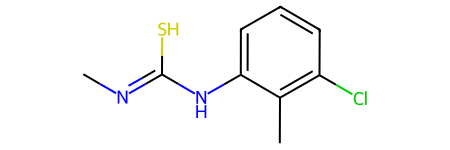

CN=C(S)NC1=CC=CC(Cl)=C1C


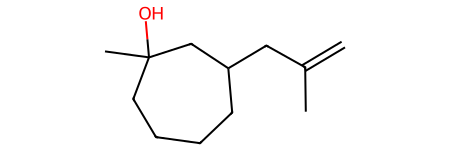

C=C(C)CC1CCCCC(C)(O)C1
21


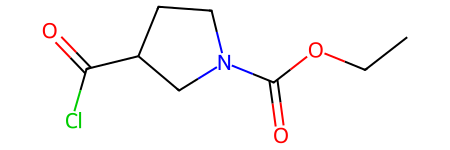

CCOC(=O)N1CCC(C(=O)Cl)C1


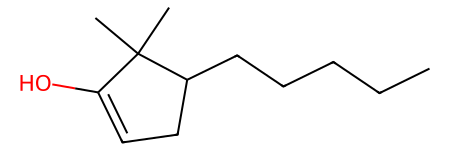

CCCCCC1CC=C(O)C1(C)C
22


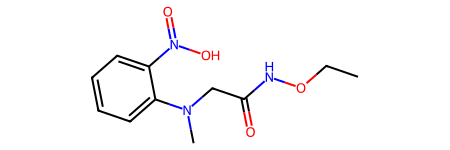

CCONC(=O)CN(C)C1=CC=CC=C1N(=O)O


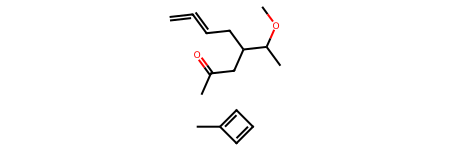

C=C=CCC(CC(C)=O)C(C)OC.CC1=CC=C1
23


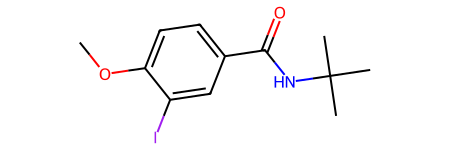

COC1=CC=C(C(=O)NC(C)(C)C)C=C1I


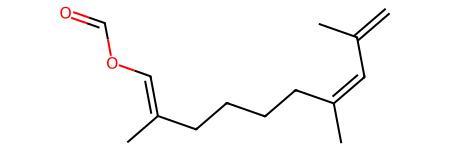

C=C(C)C=C(C)CCCCC(C)=COC=O
24


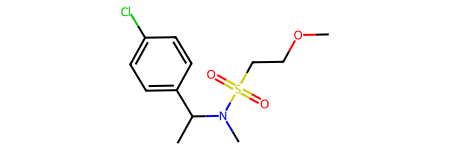

COCCS(=O)(=O)N(C)C(C)C1=CC=C(Cl)C=C1


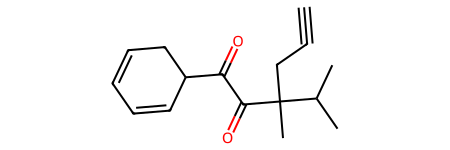

C#CCC(C)(C(=O)C(=O)C1C=CC=CC1)C(C)C
25


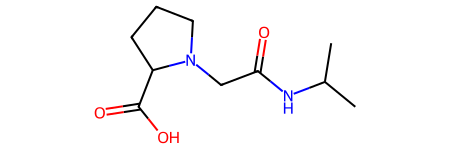

CC(C)NC(=O)CN1CCCC1C(=O)O


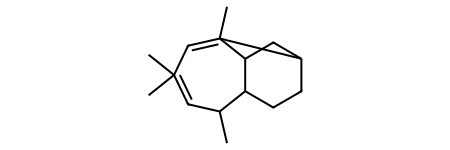

CC1C=C(C)(C)C=C2(C)C3CCC1C2C3
26


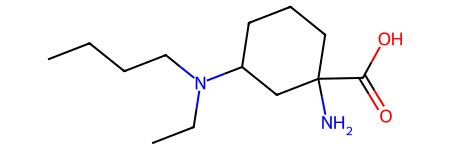

CCCCN(CC)C1CCCC(N)(C(=O)O)C1


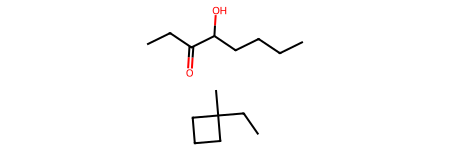

CCC1(C)CCC1.CCCCC(O)C(=O)CC
27


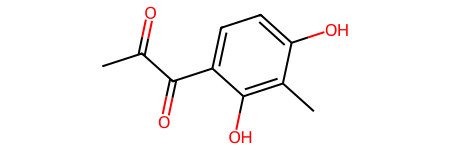

CC(=O)C(=O)C1=CC=C(O)C(C)=C1O


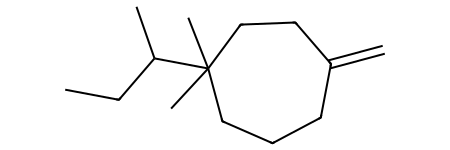

C=C1CCCC(C)(C)(C(C)CC)CC1
28


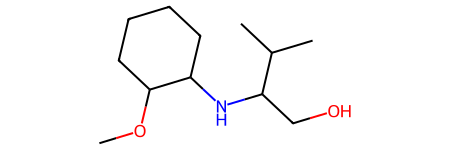

COC1CCCCC1NC(CO)C(C)C


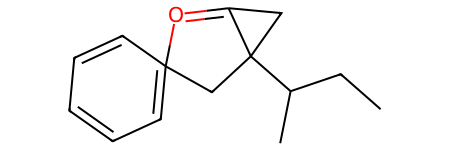

CCC(C)C12CC1=OC1(=CC=CC=C1)C2
29


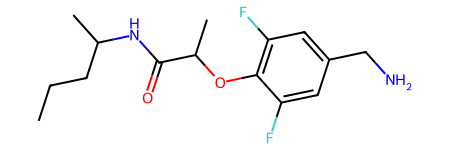

CCCC(C)NC(=O)C(C)OC1=C(F)C=C(CN)C=C1F


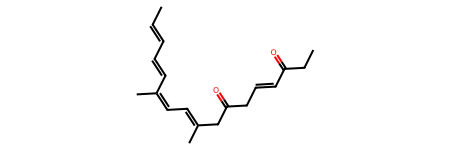

CC=CC=CC(C)=CC=C(C)CC(=O)CC=CC(=O)CC
30


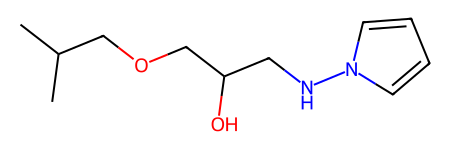

CC(C)COCC(O)CNN1C=CC=C1


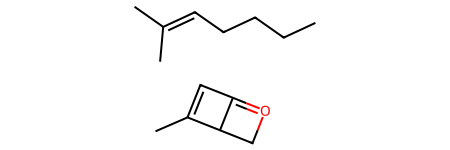

CC1=CC2=OCC12.CCCCC=C(C)C
31


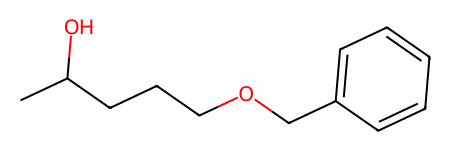

CC(O)CCCOCC1=CC=CC=C1


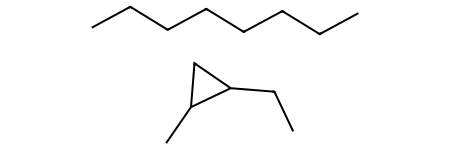

CCC1CC1C.CCCCCCCC


In [16]:
print("%s to %s" % (class_1, class_2))
for i in range(min(32, len(before_1_to_2_mols))):
    print(i)
    IPython.display.display(plot_molecule(before_1_to_2_mols[i]))
    print(rdkit.Chem.MolToSmiles(before_1_to_2_mols[i]))
    IPython.display.display(plot_molecule(after_1_to_2_mols[i]))
    print(rdkit.Chem.MolToSmiles(after_1_to_2_mols[i]))
    
print("%s to %s" % (class_2, class_1))
for i in range(min(32, len(before_2_to_1_mols))):
    print(i)
    IPython.display.display(plot_molecule(before_2_to_1_mols[i]))
    print(rdkit.Chem.MolToSmiles(before_2_to_1_mols[i]))
    IPython.display.display(plot_molecule(after_2_to_1_mols[i]))
    print(rdkit.Chem.MolToSmiles(after_2_to_1_mols[i]))